<a href="https://colab.research.google.com/github/cherynej/tri-unitary/blob/develop/HW2_solutions_CJ_ETH_thermalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to explore the eigenstate thermalization hypothesis (ETH) and thermalization in quenches from initial states. 

Some useful references: 
1. Srednicki, The approach to thermal equilibrium in quantized chaotic systems; https://arxiv.org/abs/cond-mat/9809360v2

2. Buegeling, Moessner, Haque, Finite-size scaling of eigenstate thermalization; https://arxiv.org/abs/1308.2862

3. D'Alessio, Kafri, Polkovnikov, Rigol, From Quantum Chaos and Eigenstate Thermalization to Statistical Mechanics and Thermodynamics; https://arxiv.org/abs/1509.06411 (longer review article)




# Useful Functions #

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy import linalg
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
def gen_s0sxsysz(L): 
    sx = sparse.csr_matrix([[0., 1.],[1., 0.]]) 
    sy = sparse.csr_matrix([[0.,-1j],[1j,0.]]) 
    sz = sparse.csr_matrix([[1., 0],[0, -1.]])
    s0_list =[]
    sx_list = [] 
    sy_list = [] 
    sz_list = []
    I = sparse.eye(2**L, format='csr', dtype='complex')
    for i_site in range(L):
        if i_site==0: 
            X=sx 
            Y=sy 
            Z=sz 
        else: 
            X= sparse.csr_matrix(np.eye(2)) 
            Y= sparse.csr_matrix(np.eye(2)) 
            Z= sparse.csr_matrix(np.eye(2))
            
        for j_site in range(1,L): 
            if j_site==i_site: 
                X=sparse.kron(X,sx, 'csr')
                Y=sparse.kron(Y,sy, 'csr') 
                Z=sparse.kron(Z,sz, 'csr') 
            else: 
                X=sparse.kron(X,np.eye(2),'csr') 
                Y=sparse.kron(Y,np.eye(2),'csr') 
                Z=sparse.kron(Z,np.eye(2),'csr')
        sx_list.append(X)
        sy_list.append(Y) 
        sz_list.append(Z)
        s0_list.append(I)

    return s0_list, sx_list,sy_list,sz_list


def gen_op_total(op_list):
    L = len(op_list)
    tot = op_list[0]
    for i in range(1,L): 
        tot = tot + op_list[i] 
    return tot

def gen_op_prod(op_list):
    L= len(op_list)
    P = op_list[0]
    for i in range(1, L):
        P = P*op_list[i]
    return P

def gen_interaction_kdist(op_list, op_list2=[],k=1, bc='obc'):
    L= len(op_list)

    if op_list2 ==[]:
        op_list2=op_list
    H = sparse.csr_matrix(op_list[0].shape)
    Lmax = L if bc == 'pbc' else L-k
    for i in range(Lmax):
        H = H+ op_list[i]*op_list2[np.mod(i+k,L)]
    return H

def gen_state_bloch(thetaList, phiList):
    L=len(thetaList)
    psi = np.kron([np.cos(thetaList[0]/2.),np.exp(1j*phiList[0])*np.sin(thetaList[0]/2.)],
                  [np.cos(thetaList[1]/2.),np.exp(1j*phiList[1])*np.sin(thetaList[1]/2.)])
    for i in range(2,L):
        psi = np.kron(psi, [np.cos(thetaList[i]/2.),np.exp(1j*phiList[i])*np.sin(thetaList[i]/2.)])
    return psi


# Model #

As a model Hamiltonian, we'll work with the transverse field Ising model (TFIM) with an additional longitudinal field: 

$H = J \sum_i \sigma_i^z \sigma_{i+1}^z + h_x\sum_i \sigma_i^x  + h_z \sum_i \sigma_i^z $

When $h_z=0$, this is the TFIM you looked at in the last HW. The TFIM can be re-written as a model of non-interacting Majorana fermions and is thus a `free' integrable model. The additional longitudinal field with strength $h_z$ makes the model non-integrable and breaks the Ising symmetry.

Choose your parameters as below:


In [4]:
def gen_MixedFieldIsing(L,J,hz,hx, BC='obc'):
  s0, sx, sy, sz = gen_s0sxsysz(L)
  H = J*gen_interaction_kdist(sz, k=1, bc=BC) + hx*gen_op_total(sx) + hz*gen_op_total(sz)
  H = H + .2*hz*sz[0] # I broke inversion symmetry because I'm lazy
  return H



In [5]:
J=1
hz = (np.sqrt(5)+1)/4.
hx = (np.sqrt(5)+5)/8.
BC = 'obc'

The choice of parameters above may seem strange. They are chosen from this paper: https://arxiv.org/abs/1306.4306 and these parameters have been found to make the model robustly non-integrable even at small sizes. While any non-zero $h_z$ is non-integrable, in practice one may need to go to very large sizes and/or very late times to see this. 

# Question 1: Energy and Entropy (15 pts) #

a. Construct and diagonalize the Hamiltonian for the model above for L=12 (use the helper functions). Plot the normalized distribution of eigenenergies as a function of energy using plt.hist or np.histogram. This serves as a proxy for the density of states (DOS). [5pts]

b. What is the shape of the DOS? Next week, we will contrast this DOS with that of a dense random matrix, which has a semicircular DOS.  [1pt]

c. The bandwith of a spectrum is defined as the difference in energy between the highest and lowest energy states. How does the bandwidth scale with system size $L$? It is preferred for you to answer this part by general analtyic reasoning, but it is acceptable to answer by simulating different $Ls$. [1pt]

d. How does the standard deviation of the DOS scale with $L$? This represents the energy window where most of the eigenstates live, which scales differently from the bandwidth. It is preferred for you to answer this part by analtyic reasoning, but it is acceptable to answer by simulating different $Ls$. Your analytic answer can be given on general terms and does not need to specifically consider details of the model Hamiltonian.  [1pt]

<Figure size 720x480 with 0 Axes>

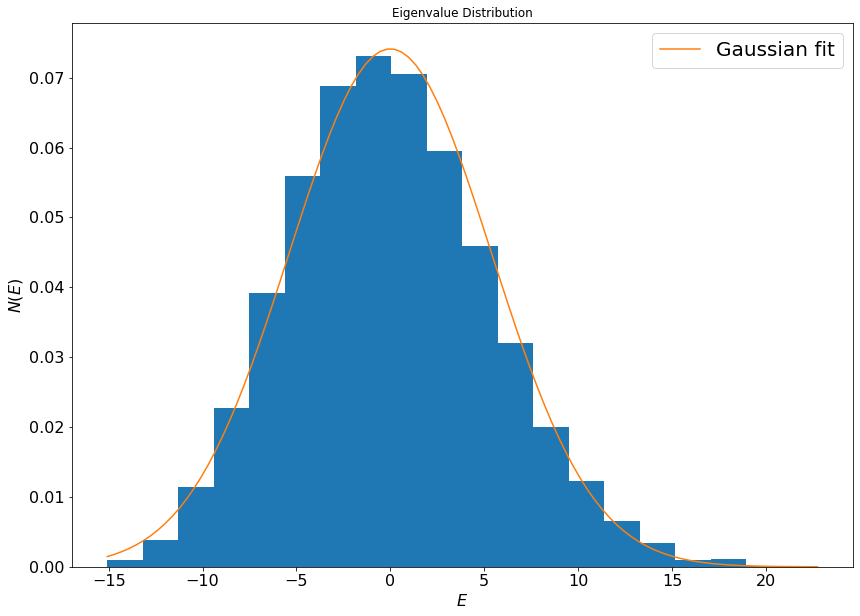

In [ ]:
### Q1 a)

L=12
s0, sx, sy, sz = gen_s0sxsysz(L)
H=gen_MixedFieldIsing(L,J,hz,hx, BC='obc')
evals, evecs = linalg.eigh(H.toarray())

# _=
fig=plt.figure(dpi=120)
plt.figure(figsize=(14,10))
plt.hist(evals, bins=20, density=True); 
mu=np.mean(evals)
sigma=np.std(evals)
x=np.linspace(evals[0],evals[-1],100)
plt.plot(x, np.exp(-(x-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2), label='Gaussian fit')
plt.title('Eigenvalue Distribution')
plt.legend(fontsize=20)
plt.xlabel(r'$E$',fontsize=16); 
plt.ylabel(r'$N(E)$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Q1 b) The DOS is a Gaussian for local Hamiltonians. This is different from a random matrix, where the dos is a semi-circle. A quick combinatorial argument for the Gaussian: If we consider $H=\sum_{i=1}^L Z_i$, then the number of states at a particular energy $E=n_{up}(+1)+n_{down}(-1)=2n_{up}-L$ is given by $N(E)=\binom{L}{n_d}=\binom{L}{E+L/2}$, which is maximed when $n_u=L/2 \implies E=0$. Plotting this, we can guess the Gaussian dos:



Text(0, 0.5, '$N(E)$')

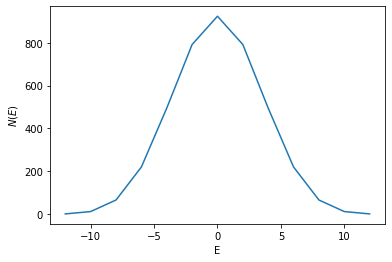

In [82]:
from scipy.special import comb

nList = np.arange(-L, L+1,2)
NE=[comb(L, (L+n)//2) for n in nList]
plt.plot(nList, NE)
plt.xlabel('E')
plt.ylabel(r'$N(E)$')

Q1 c) The MB bandwidth is extensive $\sim V= L^d$, where $d=1$ for a 1d spin chain. This can again be understood with the simple toy Hamiltonian above, for $H=\sum_{i=1}^L Z_i$, the minimum and maximum energy scale with system size, $E_{min/max} = \mp L$. 

Q1 d) Given c) (MB bandiwdth $\sim L$) and b) (Gaussian dos), we expect std. dev. $\sim \sqrt{V} = \sqrt{L^d}$.


Recall that the entropy is given by $S=\ln \Omega$, where $\Omega$ is the multiplicity of states consistent with a given set of thermodynamic parameters (such as energy, volume etc.), and we set $k_B = 1$. The density of states $N(E)$ is the number of eigenstates with energy $E$ per unit volume per unit energy and is a proxy for the entropy. 

From the curve of entropy vs. energy, we can extract the temperature conjugate to each energy via $dS/dE = 1/T$. `Infinite temperature' corresponds to the energy density with the maximum entropy. Recall from your stat mech class that temperatures can be negative and positive (the slopes $dS/dE$ for your plot can be both positive and negative). A negative temperature $-T_0$ for $H$ simply corresponds to positive temperature $T_0$ for the Hamiltonian $-H$. 

Indeed, we can find the equilibrium energy corresponding to a given temperature in the usual way using the Gibbs ensemble:
$\langle E\rangle_T =  \frac{1}{Z} \sum_\alpha e^{-E_\alpha/T}E_\alpha$, where the sum is over the complete basis of energy eigenstates $|E_\alpha\rangle$ and we have assumed there are no continuous symmetries other than energy.  

Finally, note that temperature is intensive and determined by the energy *density*, $E/V$. Recall that the uncertainty in the average energy at a given temperature in the canonical ensemble is $\Delta E \propto \sqrt{V}$. Thus, all states in a large window $\Delta E$ around $\langle E\rangle_T$ have the same temperature.  


e. What is the temperature corresponding to the ground state (i.e. the state at the bottom of the many-body spectrum?) [1pt]

f. What is the energy corresponding to infinite temperature? Where does this energy live in the many-body spectrum? [1pt]

g. What is the temperature corresponding to the highest excited state (i.e. the state at the top of the many-body spectrum?) [1pt]

h. Consider temperatures $T=0.1, 1, 10, 100, -100, -10, -1, -0.1$. Numerically compute the expectation value of the energy for each of these temperatures. Plot these as (labeled) vertical lines on the DOS plot. Also mark the infinite temperature energy computed in f. [4pts]

Q1 e) $T=0^+$. This can be understood by looking at $\langle E\rangle_{T} = \frac{1}{Z} \sum_{\alpha} e^{-E_{\alpha}/T} E_{\alpha}$. If we want to pick out the GS, which has $E=E_{min} \sim -L$, then we want to send $T \rightarrow 0$ from the positive numbers. This creates an exponential weight toward the GS in the sum. 

Q1 f) $\langle E\rangle_{\infty} = \frac{1}{Z} \sum_{\alpha} e^{-E_{\alpha}/\infty} E_{\alpha} =  \frac{1}{Z} \sum_{\alpha}  E_{\alpha}= \frac{1}{Z} Tr(H)$. It lives at the center of the MB spectrum, where the slope $dS/dE = 1/T$ approaches $0$. 

Q1 g) $T=0^-$. Same reasoning as in e), but this time $E=E_{max} \sim + L$, so we want to approach from the negative numbers. 


<Figure size 720x480 with 0 Axes>

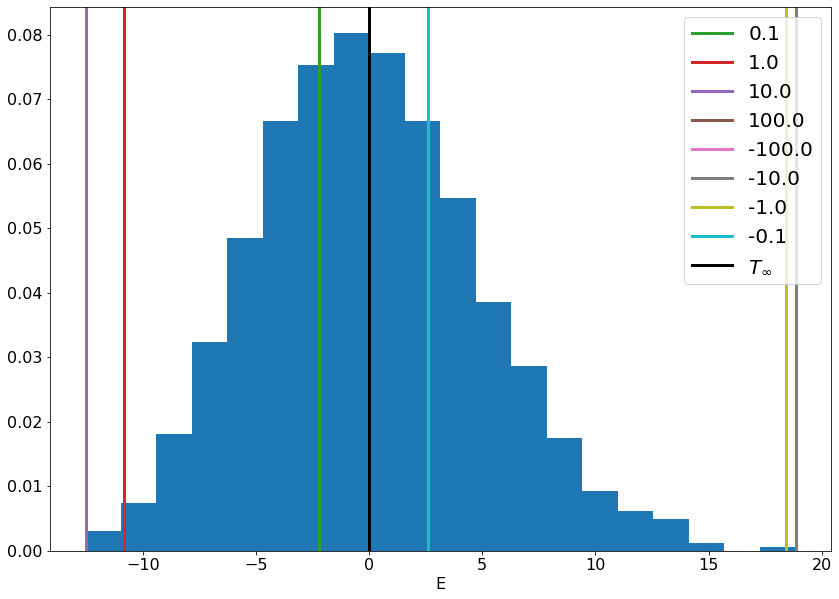

In [45]:
### Q1 h)

Ts = np.asarray([0.1,1,10,100,-100,-10,-1,-0.1])
Z = np.sum(np.exp(-1*np.outer(evals,Ts)),axis=0)
E = np.dot(np.exp(-1*np.outer(evals,Ts)).T,evals)/Z
Einf = np.sum(evals)/2**L

# _=
fig=plt.figure(dpi=120)
plt.figure(figsize=(14,10))
plt.hist(evals,density=True,bins=20)
for ind,Ea in enumerate(E):
  plt.axvline(Ea,color='C'+str(ind+2),label=str(Ts[ind]),lw=3)
plt.axvline(Einf,color='k',label="$T_\infty$",lw=3)
plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('E',fontsize=16)
plt.show()

# Question 2: Diagonal ETH (20 pts)#



We will now verify the (diagonal) ETH for the non-integrable transverse field Ising chain, for a particular local observable $A= \sigma_{L/2}^x$. The statement of diagonal ETH is: 

$A_{\alpha \alpha}  = \mathcal{A}(E) = \langle A\rangle_T + O(1/L) +O(e^{-S/2})$ (Equation 1)

where $|\alpha\rangle$ is a many-body eigenstate with eigenenergy $E$, and $\mathcal{A}(E)$ is a smooth function of $E$, and  $\langle A\rangle_T = \frac{1}{Z}\mbox{Tr } A e^{-H/T}$ is the thermal expectation value of $A$ at a temperature $T$ corresponding to the energy $E$, and $S(E) \propto L$ is the entropy, so that $e^{S(E)}$ is the relevant Hilbert space dimension at energy $E$. 

Conditions to verify: 
1. The diagonal eigenstate expectation value (EEV) $A_{\alpha\alpha}$ varies smoothly as a function of the energy of the eigenstates. 
2. The eigenstate-to-eigenstate fluctuations in the EEVs decrease (exponentially) with increasing system size. Note that this is closely related to point 1. The energy difference between neighboring eigenstates in the middle of the many-body spectrum is exponentially small in $L$. Thus, if $O(E)$ is a smooth function of $E$, we expect differences between nearby eigenstate expectation values to be exponentially close. This is the $O(e^{-S/2})$ part in Equation (1) above. Note that all states within some $O(1)$ energy window $\Delta E$ have the same energy density and hence the same temperature, so $\langle A\rangle_T$ is the same for all states in the window. 

2. The eigenstate expectation value of the observable agrees with the expected thermodynamic answer, $\langle A\rangle_T$ at the same temperature. However, note that the difference between the EEV and $\langle A\rangle_T$ only decreases polynomially with $1/L$ (similar in spirit to the agreement between canonical and microcanonical ensembles in standard stat mech, up to poly(1/L) corrections). 

Useful references: 
1. Srednicki, The approach to thermal equilibrium in quantized chaotic systems; https://arxiv.org/abs/cond-mat/9809360v2

2. Buegeling, Moessner, Haque, Finite-size scaling of eigenstate thermalization; https://arxiv.org/abs/1308.2862

a. Make scatter plots of $A_{\alpha \alpha}$ vs. $E_\alpha$ for $L=8,10,12$. Do you visually see the distributions narrowing with increasing $L$? You may find the hist2d function in matplotlib useful. (5pts)

b. Pick an array of logarithmically spaced temperatures between 0.1 and $10^{10}$ (check out np.logspace). For each temperature in your list, compute $\langle A\rangle_T$ and  $\langle H\rangle_T$. Plot $\langle A\rangle_T$ vs.  $\langle H\rangle_T$ on the scatter plot in (a) for the largest system size. Does the thermal curve track the scatter plot? (5pts)

c. Pick an energy window near the middle of the many-body spectrum (i.e. around the energy corresponding to infinite temperature). Numerically compute the measure for EEV fluctuations in equation 2 of https://arxiv.org/pdf/1308.2862.pdf, and plot its scaling with $L$. Does it agree with the expected answer $e^{-S(E)/2}\sim 2^{-L/2}$ at infinite $T$? (5pts)

d. Set $h_z=0$ and repeat a-c. When $h_z=0$, the model is the TFIM which is an integrable non-interacting model after performing a Jordan-Wigner transformation. Thus, we do not expect ETH to hold for this model, and expect fluctuations to be be much larger. Do you see this?  (5pts)

8
10
12


<Figure size 720x480 with 0 Axes>

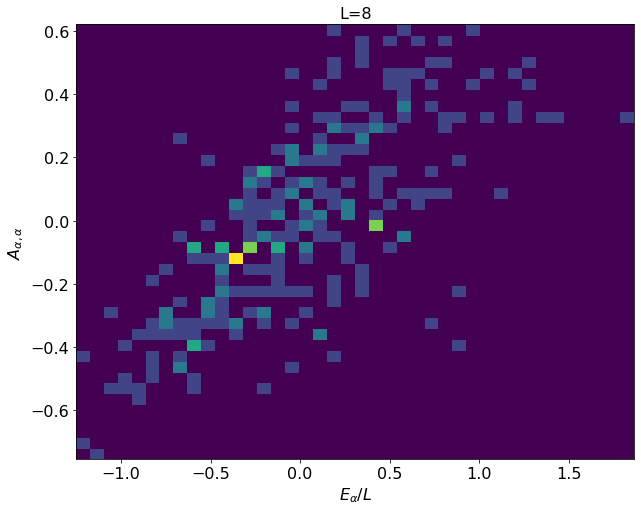

<Figure size 720x480 with 0 Axes>

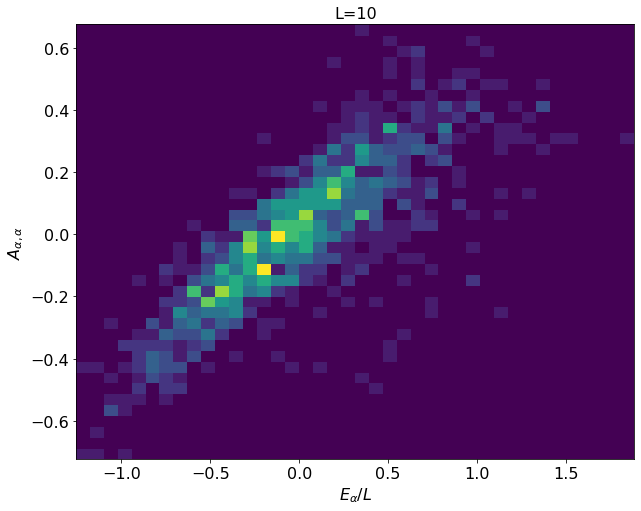

<Figure size 720x480 with 0 Axes>

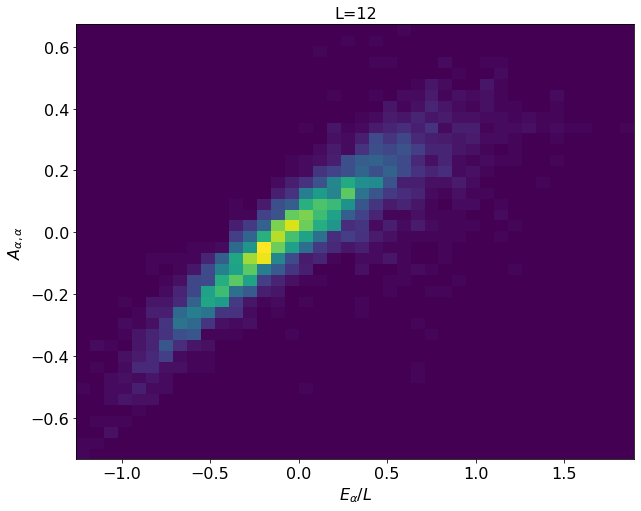

In [ ]:
### Q2 a)


def op_EEV_MixedFieldIsing(Op,L, J, hz, hx,BC='obc'):
  s0, sx, sy, sz = gen_s0sxsysz(L)
  H = gen_MixedFieldIsing(L, J, hz, hx,BC)
  evals, evecs = linalg.eigh(H.toarray())
  Op_EEV = np.sum(np.conj(evecs)*(Op.dot(evecs)), axis = 0)
  return evals, Op_EEV

for L in [8,10,12]:
  s0, sx, sy, sz = gen_s0sxsysz(L)
  Op = sx[L//2]
  evals, opeev= op_EEV_MixedFieldIsing(Op,L, J=1, hz = (np.sqrt(5)+1)/4, hx = (np.sqrt(5)+5)/8)
  print(L)

  fig=plt.figure(dpi=120)
  plt.figure(figsize=(10,8))
  plt.hist2d(evals/L, opeev, 40)
  plt.ylabel(r'$A_{\alpha,\alpha}$',fontsize=16)
  plt.xlabel(r'$E_{\alpha}/L$',fontsize=16)
  plt.title('L=%d'%L,fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16) 


### Ans: We clearly see the fluctuations narrowing with system size. 

In [ ]:
### Q2 b)

L=12
s0, sx, sy, sz = gen_s0sxsysz(L)
Op = sx[L//2]
evals, opeev= op_EEV_MixedFieldIsing(Op,L, J=1, hz = (np.sqrt(5)+1)/4, hx = (np.sqrt(5)+5)/8)

Ts=np.logspace(-1,10,100)
EList = np.zeros(len(Ts))
OList = np.zeros(len(Ts))
for t in range(len(Ts)):
  Gibbs = np.exp(-evals/Ts[t])
  Z = np.sum(Gibbs)
  EList[t] = np.dot(evals, Gibbs)/Z
  OList[t] = np.dot(Gibbs, opeev)/Z

(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 <a list of 10 Text major ticklabel objects>)

<Figure size 720x480 with 0 Axes>

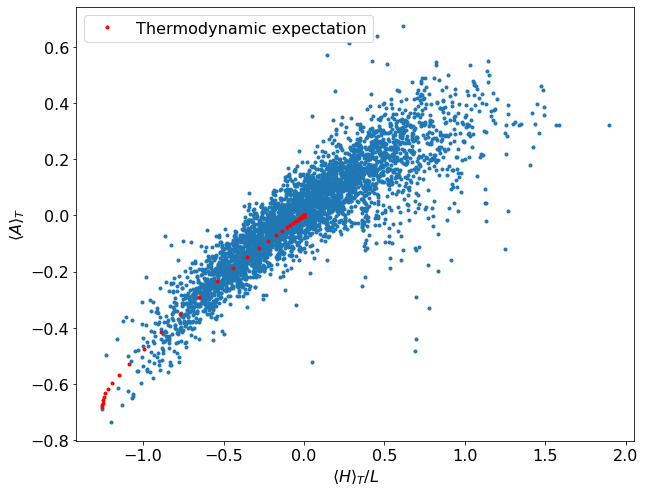

In [ ]:
fig=plt.figure(dpi=120)
plt.figure(figsize=(10,8))
plt.plot(evals/L, opeev, '.')
plt.xlabel(r'$\langle H\rangle_T/L$',fontsize=16)
plt.ylabel(r'$\langle A \rangle_T$',fontsize=16)
plt.plot(EList/L, OList, 'r.', label = 'Thermodynamic expectation')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 


### Ans: The thermal curve does track the scatter plot!

In [ ]:
### Q2 c)

def op_EEV_fluct_ising(L, J, hz, hx,BC='obc'):
  deltaE=0.025*L #same width of energy shell as in reference paper
  s0, sx, sy, sz = gen_s0sxsysz(L)
  H = gen_MixedFieldIsing(L, J, hz, hx,BC)

  evals, evecs = linalg.eigh(H.toarray())

  Op = sx[L//2] #for the ising model, Sx is a good observable since it has non-zero matrix element between states n and m

  Op_EEV = np.sum(np.conj(evecs)*(Op.dot(evecs)), axis = 0)
  
  index_min=(2**L)//2 - (2**L)//10 #as suggested in the reference paper, we consider only the middle 20% of the spectrum.
  index_max=(2**L)//2 + (2**L)//10

  Op_EEV_mc=[];

  for n in range(index_min,index_max+1):
    index_left=np.argmax(evals >= evals[n] - deltaE)
    index_right=np.argmax(evals > evals[n] + deltaE)
    Op_EEV_mc.append(np.mean(Op_EEV[index_left:index_right]))

  sigmaOp=(Op_EEV[index_min:index_max+1]-Op_EEV_mc)**2;

  return Op_EEV[index_min:index_max+1], Op_EEV_mc, sigmaOp

8
10
12


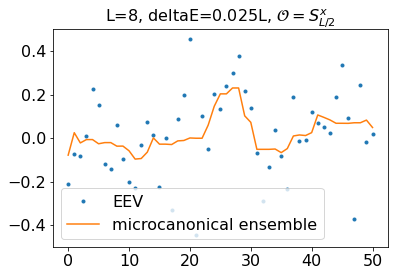

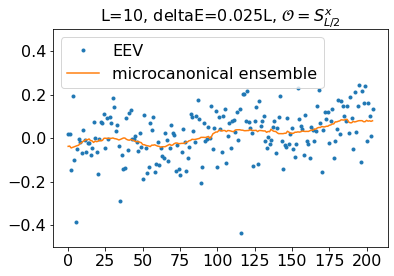

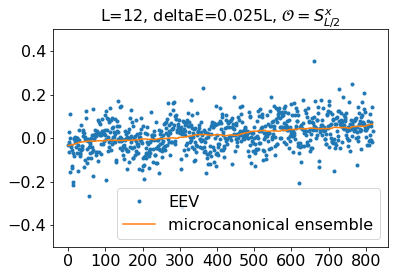

In [ ]:
### We first plot the operator EEV averaged over the microcanonical ensemble against the non-average data to see if it's doing an ok job.

Ls = [8,10,12]
J=1
hz= (np.sqrt(5)+1)/4
hx= (np.sqrt(5)+5)/8

sigmaOp_vec=[];

for L in Ls:
  print(L)
  Op_EEV_mid20, Op_EEV_mc, sigmaOp = op_EEV_fluct_ising(L, J, hz, hx,BC='obc')

  plt.figure()
  plt.plot(Op_EEV_mid20,'.', label='EEV')
  plt.plot(Op_EEV_mc,label='microcanonical ensemble')
  plt.title('L=%d, deltaE=0.025L, $\mathcal{O}=S^x_{L/2}$' %L,fontsize=16)
  plt.ylim(-0.5, 0.5)
  plt.legend(fontsize=16)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16) 

  sigmaOp_vec.append(np.mean(sigmaOp))

### We can clearly see the EEV's converging to a narrow band around the microcanonical average with increasing L. 

(array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 <a list of 5 Text major ticklabel objects>)

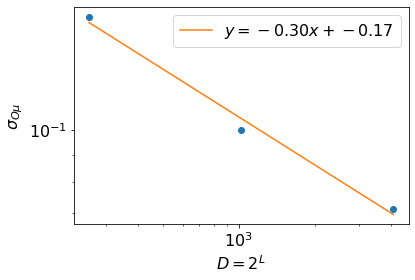

In [ ]:
### Finally, let us calculate how the fluctuations narrow with system size.

x = 2**np.array(Ls)
y = np.sqrt(sigmaOp_vec)
plt.loglog(x,y, 'o')
slope, b = np.polyfit(np.log(2**np.array(Ls[:])),np.log(np.sqrt(sigmaOp_vec[:])),1)
plt.loglog(x,np.exp(b)*(x**slope), label = r'$y=%.2fx + %.2f$'%(slope,b))
plt.xlabel(r'$D=2^L$',fontsize=16)
plt.ylabel(r'$\sigma_{O\mu}$',fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 



While fitting a line to three points is far from ideal, we are limited by finite sizes for this HW. In practice, we would use symmetries and a computational cluster to consider a few larger sizes. 

We see a trend broadly consistent with the exponential decay of fluctuations with increasing $L$. The decay exponent $\sigma \sim D^{-.35}$ is less than the expected $D^{-.5}$, but we see that the slope is increasing with increasing $L$ and the largest two sizes give a decay exponent closer to the expected -0.5. Note that we typically consider either odd sizes or even sizes because finite-size systems often have strong even-odd effects. These can arise for mundane reasons (odd chains have an exact center, while even chains don't and hence the effects of the edges can look different between the two) or more profound reasons (for example, $P_x = \prod_i \sigma_i^x$ and $P_y= \prod_i \sigma_i^y$ commute for even length chains and may act as simultaneous symmmetries in some models, while they do not commute for odd length chains). 

# Question 3: Quenches (25 pts)#

Next, we will consider dynamics starting from general initial states $|\psi_0\rangle$. Thermalization means $\langle \psi(t)|A|\psi(t)\rangle \rightarrow  \langle A\rangle_T$ at late times, where the temperature is set by the energy density of the initial state. The instantaneous fluctuations in time are again supposed to be exponentially small in $L$, scaling as $e^{-S/2}$.  

a. Fix L=10. Pick initial product states $|\psi_0\rangle $ with different expectation values of energies spanning the spectrum. It is easiest to choose product states in the $Z$ basis, which are of the form $|\uparrow \downarrow \cdots \uparrow\rangle$.  Note that the diagonal entries of $H$ are equal to $\langle n|H|n\rangle$ for product states $|n\rangle$ in the $Z$ basis. By sorting the diagonal entries, pick 10 indices $n$ corresponding to (roughly) equally spaced energy expectation values. Indicate these energies as vertical lines on the DOS. (5pts)

b. Obtain $\langle A\rangle_T$ for each of the initial states you picked in a. Note that it is easiest to do this approximately by picking a finely spaced list of temperatures, and obtaining $\langle A\rangle_T$ and  $\langle H\rangle_T$  for this list, as in Quaestion 2. These parametric plot of $\langle A\rangle_T$ vs  $\langle H\rangle_T$ should look smooth. You can then read off the (interpolated) expected thermal $\langle A\rangle_T$s corresponding to the energies of the different initial states in (a). (5pts)

c. Plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for each of the initial states in (a) on the same plot using different colors. Add dashed lines indicating the expected thermal values. Do the late-time expectation values agree with the thermal values? (5pts)

d. Fix a particular initial state corresponding to infinite temperature, and plot $\langle \psi(t)|A|\psi(t)\rangle$ vs. $t$ for $L=8,10,12$ on the same plot. Do you see the late time fluctuations narrowing with increasing $L$? Verify that the late-time fluctuations scale as $e^{-S/2}\sim 2^{-L/2}$. (You may find it convenient to start with a $+Y$ product state which is at infinite temperature and can allow you to easily compare across sizes; the gen_state_bloch function will help you obtain such a state). (5pts)

e. No numerics for this part. Expand $\langle \psi(t)|A|\psi(t)\rangle$  in the eigenbasis of the Hamiltonian, separating the sums between time-independend diagonal contributions and the time-dependent off-diagonal ones. Use the ETH ansantz for off-diagonal matrix elements, and consider a very late time $t\sim 2^L$ for simplicity, so that you can assume all the phases $e^{-i(E_\alpha -E_\beta)t}$ are random complex numbers. Also assume that your eigenvectors look like random vectors. By considering the scaling of all the different compnents, show that the instantaneous off-diagonal fluctuation scales as $e^{-S/2}$ for this late time. (5pts)





<Figure size 720x480 with 0 Axes>

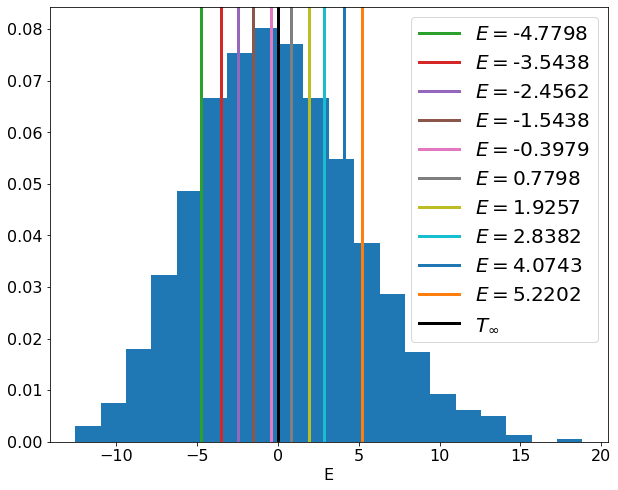

In [121]:
### Q3a)

def nearest_index(array, value):
    return (np.abs(np.asarray(array) - value)).argmin()
    
def evenly_spaced_indices(array, steps):
    return [nearest_index(array, value) for value in np.linspace(np.min(array), np.max(array), steps)]

L=10
s0, sx, sy, sz = gen_s0sxsysz(L)
H=gen_MixedFieldIsing(L,J,hz,hx, BC='obc')
evals,evecs=np.linalg.eigh(H.todense())
evecs=np.asarray(evecs)
Einf = np.mean(evals)

Hdiag_sorted=np.sort(H.diagonal())
sorting_indices=np.argsort(H.diagonal())
Hdiag_central_sorted=Hdiag_sorted[2**L//10:9*2**L//10]
ind=evenly_spaced_indices(Hdiag_central_sorted,10)
sorting_indices_selected=sorting_indices[ind]
Hdiag_selected=Hdiag_central_sorted[ind]

#a)
# _=
fig=plt.figure(dpi=120)
plt.figure(figsize=(10,8))
plt.hist(evals,density=True,bins=20)
for i in range(len(Hdiag_selected)):
  E0 = Hdiag_selected[i]
  plt.axvline(E0,color='C'+str(i+2),label='$E=$%.4f' %E0,lw=3)
plt.axvline(Einf,color='k',label="$T_\infty$",lw=3)
plt.legend(fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('E',fontsize=16)
plt.show()


<Figure size 720x480 with 0 Axes>

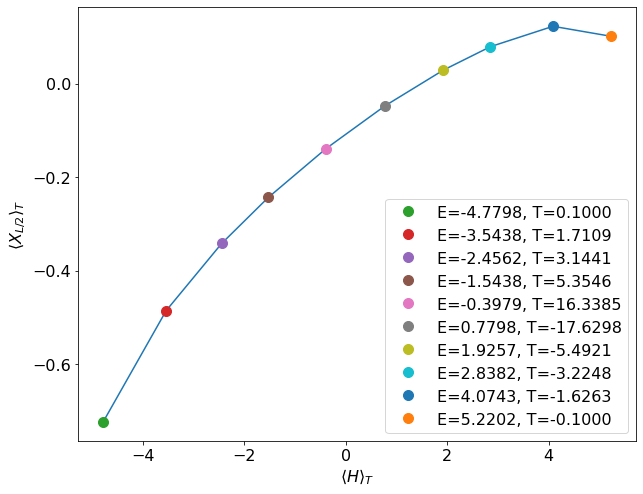

In [75]:
### Q3b) 

Op=sx[L//2]
opeev=np.sum(np.conj(evecs_selected_Hbasis)*(Op.dot(evecs_selected_Hbasis)), axis = 0)
Ts = np.append( np.logspace(-1,10,1000) , -1*np.logspace(-1,10,1000)[::-1] )

EList = np.zeros(len(Ts))
OList = np.zeros(len(Ts))
for t in range(len(Ts)):
  Gibbs = np.exp(-Hdiag_selected/Ts[t])
  Z = np.sum(Gibbs)
  EList[t] = np.dot(Hdiag_selected, Gibbs)/Z
  OList[t] = np.dot(Gibbs, opeev)/Z

# _=
Tcanonical=np.zeros(len(ind))
Ocanonical=np.zeros(len(ind))
Ecanonical=np.zeros(len(ind))
for i, index in enumerate(ind):
  E0 = Hdiag_selected[i]
  t = np.argmin(np.abs(EList-E0)) #find the temperature that corresponds to the energy of the current state from the canonical calculation above
  #print([E0,t,Ts[t]])
  Tcanonical[i] = Ts[t]
  Ocanonical[i] = OList[t]
  Ecanonical[i] = EList[t]

fig=plt.figure(dpi=120)
plt.figure(figsize=(10,8))
plt.plot(Ecanonical,Ocanonical,'-')
for i in range(len(ind)):
  plt.plot(Ecanonical[i],Ocanonical[i],'o',color='C'+str(i+2),markersize=10,label='E=%.4f, T=%.4f' %(Hdiag_selected[i],Tcanonical[i]))
plt.legend(fontsize=16)
plt.xlabel(r'$\langle H \rangle_T$',fontsize=16);
plt.ylabel(r'$\langle X_{L/2}\rangle_T $',fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);



In [127]:
### Q3c) 

def timeEvolution(evals, evecs, psi0, op, Times):
  OpTimesList = np.zeros(len(Times)) # be careful - specify the matrix type as complex if O(t) can be complex
  psi0Init = np.dot(np.conj(np.asarray(evecs).T), psi0) # obtain the initial state in the eigenbasis
  psi0Init = np.squeeze(psi0Init)
  OpMatList = np.dot(np.conj(np.asarray(evecs).T),(op.dot(np.asarray(evecs)))) # obtain the operator in the eigenbasis 

  for i in range(len(Times)):
      t=Times[i]
      psit = psi0Init*np.exp(-1j*evals*t) #psit in eigenbasis
      OpTimesList[i] = np.dot(np.conj(psit),OpMatList.dot(psit))
  return OpTimesList

Times = np.logspace(-2, 3, 1000)
Opt = np.zeros((len(sorting_indices_selected), len(Times)))
for i, index in enumerate(sorting_indices_selected):
  psi0 = np.zeros(2**L)
  psi0[index] = 1.
  Opt[i,:] = timeEvolution(evals, evecs, psi0, sx[L//2], Times)


<Figure size 720x480 with 0 Axes>

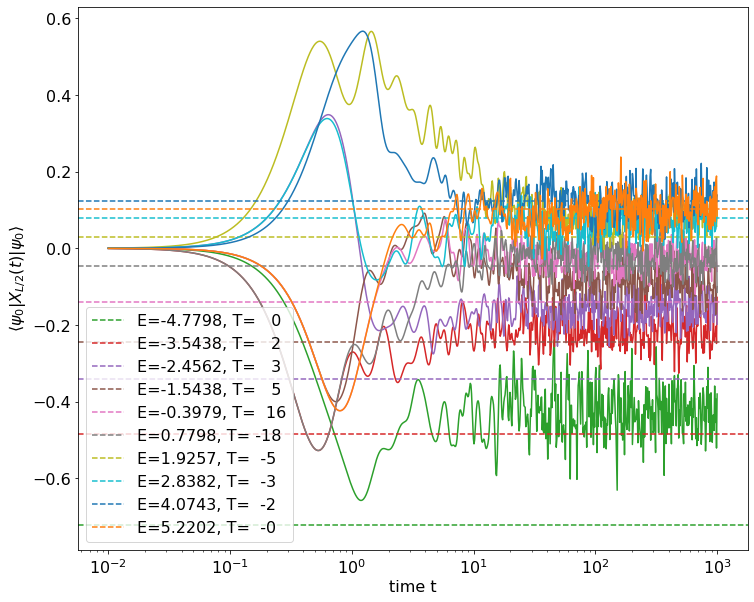

In [128]:
fig=plt.figure(dpi=120)
plt.figure(figsize=(12,10))
for i, index in enumerate(ind):
  plt.semilogx(Times, Opt[i], color='C'+str(i+2))
  plt.axhline(Ocanonical[i], linestyle='--', color='C'+str(i+2),label='E=%.4f, T=%4.f' %(Hdiag_selected[i], Tcanonical[i]))
plt.xlabel('time t',fontsize=16)
plt.ylabel(r'$\langle \psi_0|X_{L/2}(t)|\psi_0\rangle$',fontsize=16)
plt.legend(fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);


The dashed lines show the canonical thermal expectation values of $X_{L/2}(t)$ at a temperature determined by the energy density of the initial state. There is good agreemennt for states at high temperature/in the center of the energy band, but not so good agreement at low temperatures/away from the center.


In [129]:
### Q3d)

LList = [8, 10, 12]
Times = np.logspace(-2, 3, 1000)
opTimesList=np.zeros((len(LList), len(Times)))
for l, L in enumerate(LList):
  print(L)
  H = gen_MixedFieldIsing(L,J,hz,hx, BC)
  evals, evecs = linalg.eigh(H.toarray())
  s0, sx, sy,sz=gen_s0sxsysz(L)
  op = sx[L//2]
  psi0 = gen_state_bloch([np.pi/2]*L, [np.pi/2]*L) #Product state in the y-direction for which <H>=0
  opTimesList[l] = timeEvolution(evals, evecs, psi0, op, Times)

8
10
12


<Figure size 720x480 with 0 Axes>

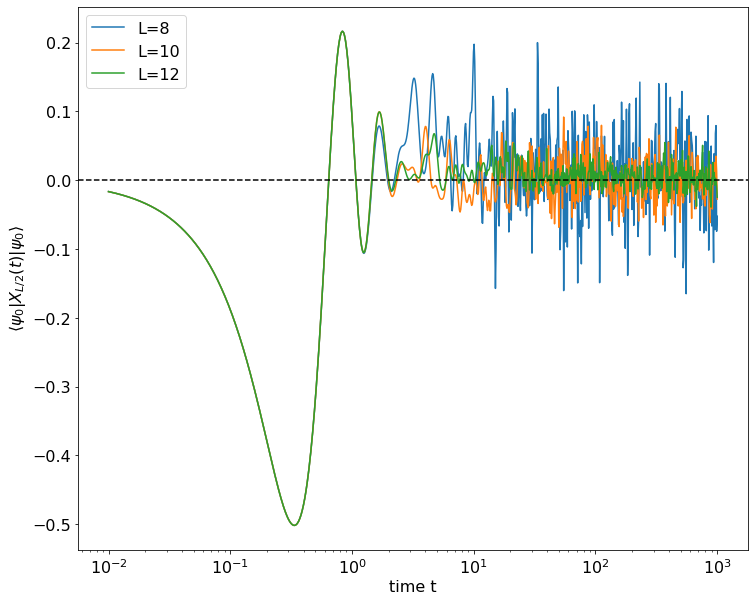

In [130]:
fig=plt.figure(dpi=120)
plt.figure(figsize=(12,10))
for l, L in enumerate(LList):
  plt.semilogx(Times, opTimesList[l], label='L=%d'%L)
plt.axhline(color='k', ls='--')
plt.legend(fontsize=16);
plt.xlabel('time t',fontsize=16);
plt.ylabel(r'$\langle \psi_0|X_{L/2}(t)|\psi_0\rangle$',fontsize=16);
plt.legend(fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

We can clearly see the fluctuations narrowing with increasing $L$. 


In [131]:
ind=np.argmin(abs(Times-100)) #get fluctuations for times larger than 100
sigma=np.std(opTimesList[:, ind:],1)



<Figure size 720x480 with 0 Axes>

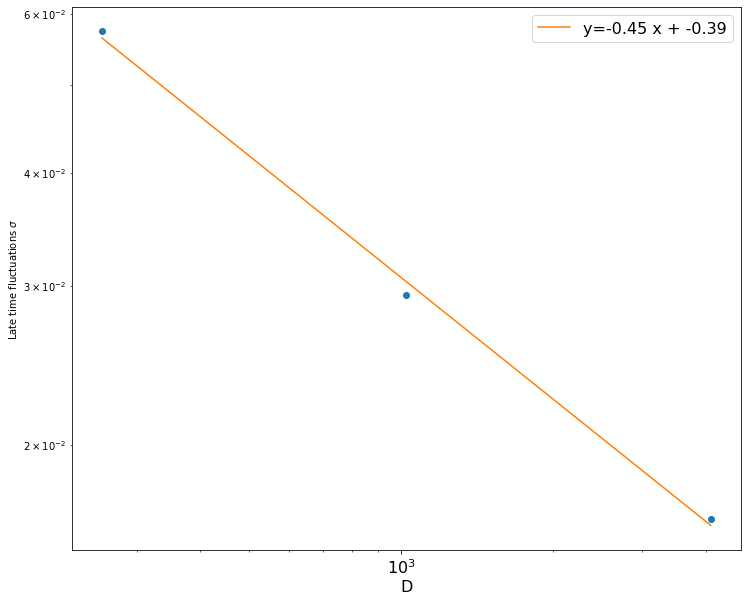

In [133]:
fig=plt.figure(dpi=120)
plt.figure(figsize=(12,10))
D=2**np.array(LList)
plt.loglog(D,sigma, 'o')
slope, b = np.polyfit(np.log(D), np.log(sigma),1)
plt.loglog(D,np.exp(b)*(D**slope), label='y=%.2f x + %.2f'%(slope, b))
plt.xlabel('D',fontsize=16)
plt.ylabel('Late time fluctuations $\sigma$')
plt.legend(fontsize=16)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

Once again, the fluctuations narrow as $D^{-.5}$ where $D=2^L$ is the Hilbert space dimension. 


Q3e)

\begin{align}
\langle \psi(t)|A|\psi(t) \rangle &= \sum_n c_n^* c_m \langle n|e^{-iHt} A e^{-iHt} |m \rangle \\
&= \sum_n |c_n|^2 A_{nn} + \sum_{n\neq m} c_n^* c_m e^{i(E_n-E_m)t} A_{nm}
\end{align}

We want to focus on the off-diagonal part for late times, $t \sim V = 2^L$. 

If we assume the eigenstates are random vectors, then $c_n \sim 1/\sqrt{V}$.

If we assume the phases are random numbers, we can use the fact that the average
amplitude of $M$ random phases grows as $\sqrt{M}$.

Then. 

\begin{align}
\sum_{n\neq m} c_n^* c_m e^{i(E_n-E_m)t} A_{nm} \sim \frac{\sqrt{V^2}}{V} \sum_{n \neq } A_{nm}
\end{align}

Finally, if we assume that the off-diagonal elements $A_{nm}$ with a givenn mean energy $\overline{E}=(E_n+E_m)/2$ and a given energy difference $\omega=E_m-E_n$ have almost identical magnitude, then 

\begin{align}
|A_{nm}| \approx A_{\overline{E},\omega} 
\end{align}

and so

\begin{align}
\sum_{n \neq m, s.t. E_n-E_m \approx \omega} |A_{nm}|^2 \approx A_{\overline{E},\omega}^2 e^{S(\overline{E}+\omega/2)} 
\end{align}

 where $S(E)$ is the microcanonical entropy at energy $E$. 
 
 
 This means that the off-diagonal fluctuations $\sqrt{\langle A_{nm}^2 \rangle - \langle A_{nm} \rangle^2}$ scale as $e^{-S(\overline{E})/2}$.

Since $S \sim O(V)$, the any off-diagonal element should be exponentially
small in $V$.
